# CV in Transformer
- **Learner** : shenhao
- **Date** : 2021.10.14

In [1]:
import math, copy, time
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Embeddings
与其他seq2seq模型类似，我们使用学习到的embedding将输入token和输出token转换为$d_{\text{model}}$维的向量。我们还使用普通的线性变换和softmax函数将解码器输出转换为预测的下一个token的概率 在我们的模型中，两个嵌入层之间和pre-softmax线性变换共享相同的权重矩阵，类似于[(cite)](https://arxiv.org/abs/1608.05859)。在embedding层中，我们将这些权重乘以$\sqrt{d_{\text{model}}}$。  

In [3]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        类的初始化函数
        d_model：指词嵌入的维度
        vocab:指词表的大小
        """
        super(Embeddings, self).__init__()
        # 之后就是调用nn中的预定义层Embedding，获得一个词嵌入对象self.lut
        self.lut = nn.Embedding(vocab, d_model)
        # 最后就是将d_model传入类中
        self.d_model = d_model

    def forward(self, x):
        """
        Embedding层的前向传播逻辑
        参数x：这里代表输入给模型的单词文本通过词表映射后的one-hot向量
        将x传给self.lut并与根号下self.d_model相乘作为结果返回
        """
        embedds = self.lut(x)
        return embedds * math.sqrt(self.d_model)

In [4]:
# embedding_size=16, input_vocab_size=10
embedding_fc = Embeddings(16, 10).to(device)
print(embedding_fc)

Embeddings(
  (lut): Embedding(10, 16)
)


In [5]:
# sentence or batch_size=1,words=5
input_X = torch.randint(0, 10, (1, 5))
input_X, input_X.shape

(tensor([[4, 2, 2, 7, 4]]), torch.Size([1, 5]))

In [6]:
embeds_x = embedding_fc(input_X)
embeds_x.shape

torch.Size([1, 5, 16])

## Positional Encodding
Positional Encodding位置编码的作用是为模型提供当前时间步的前后出现顺序的信息.因为Transformer不像RNN那样的循环结构有前后不同时间步输入间天然的先后顺序,所有的时间步是同时输入,并行推理的,因此在时间步的特征中融合进位置编码的信息是合理的.

位置编码可以有很多选择,可以是固定的,也可以设置成可学习的参数.

这里,我们使用固定的位置编码.具体地,使用不同频率的sin和cos函数来进行位置编码,如下所示:
$$PE_{pos,2i}=sin(pos/10000^{2i/d_{model}})$$  
$$PE_{pos,2i+1}=cos(pos/10000^{2i/d_{model}})$$  

其中pos代表时间步的下标索引,向量$PE_{pos}$也就是第pos个时间步的位置编码,编码长度同Embedding层.

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        位置编码器类的初始化函数

        共有三个参数，分别是
        d_model：词嵌入维度
        dropout: dropout触发比率
        max_len：每个句子的最大长度
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings
        # 注意下面代码的计算方式与公式中给出的是不同的，但是是等价的，你可以尝试简单推导证明一下。
        # 这样计算是为了避免中间的数值计算结果超出float的范围，
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [8]:
# embedding_size=15,dropout=0.1
position_encoding_layer = PositionalEncoding(16, 0.1)

In [9]:
position_enc_x = position_encoding_layer(embeds_x)
position_enc_x.shape

torch.Size([1, 5, 16])

> 可以用代码，简单看下效果

Text(69.0, 0.5, 'sequence length')

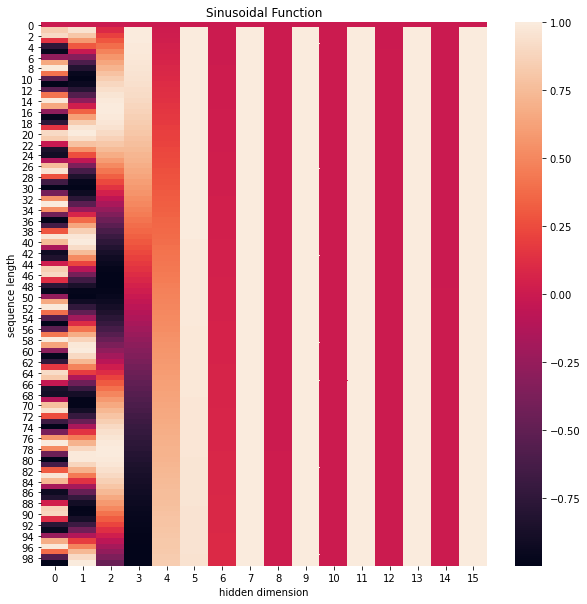

In [10]:
# 导入依赖库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


def get_positional_encoding(max_seq_len, embed_dim):
    # 初始化一个positional encoding
    # embed_dim: 字嵌入的维度
    # max_seq_len: 最大的序列长度
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    positional_encoding[1:, 0::2] = np.sin(
        positional_encoding[1:, 0::2])  # dim 2i 偶数
    positional_encoding[1:, 1::2] = np.cos(
        positional_encoding[1:, 1::2])  # dim 2i+1 奇数
    # 归一化, 用位置嵌入的每一行除以它的模长
    # denominator = np.sqrt(np.sum(position_enc**2, axis=1, keepdims=True))
    # position_enc = position_enc / (denominator + 1e-8)
    return positional_encoding

positional_encoding = get_positional_encoding(max_seq_len=100, embed_dim=16)
plt.figure(figsize=(10, 10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

## 掩码及其作用
掩码：掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有0和1；代表位置被遮掩或者不被遮掩。

掩码的作用：在transformer中，掩码主要的作用有两个，一个是屏蔽掉无效的padding区域，一个是屏蔽掉来自“未来”的信息。Encoder中的掩码主要是起到第一个作用，Decoder中的掩码则同时发挥着两种作用。

屏蔽掉无效的padding区域：我们训练需要组batch进行，就以机器翻译任务为例，一个batch中不同样本的输入长度很可能是不一样的，此时我们要设置一个最大句子长度，然后对空白区域进行padding填充，而填充的区域无论在Encoder还是Decoder的计算中都是没有意义的，因此需要用mask进行标识，屏蔽掉对应区域的响应。

屏蔽掉来自未来的信息：我们已经学习了attention的计算流程，它是会综合所有时间步的计算的，那么在解码的时候，就有可能获取到未来的信息，这是不行的。因此，这种情况也需要我们使用mask进行屏蔽。现在还没介绍到Decoder，如果没完全理解，可以之后再回过头来思考下。

mask的构造代码如下：

In [11]:
def subsequent_mask(size):
    # 生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它最后两维形成一个方阵
    "Mask out subsequent positions."
    attn_shape = (1, size, size)

    # 然后使用np.ones方法向这个形状中添加1元素，形成上三角阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 最后将numpy类型转化为torch中的tensor，内部做一个1- 的操作。这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减。
    # 如果是0，subsequent_mask中的该位置由0变成1
    # 如果是1，subsequect_mask中的该位置由1变成0
    return torch.from_numpy(subsequent_mask) == 0

In [12]:
attn_shape = (1, 10, 10)
# np.triu(m, k=0)
# k是指从主对角线开始保留
# k=0
# [[1. 1. 1. 1. 1.]
#  [0. 1. 1. 1. 1.]
#  [0. 0. 1. 1. 1.]
#  [0. 0. 0. 1. 1.]
#  [0. 0. 0. 0. 1.]]
# k=1
# [[0. 1. 1. 1. 1.]
#  [0. 0. 1. 1. 1.]
#  [0. 0. 0. 1. 1.]
#  [0. 0. 0. 0. 1.]
#  [0. 0. 0. 0. 0.]]
# k=2
# [[0. 0. 1. 1. 1.]
#  [0. 0. 0. 1. 1.]
#  [0. 0. 0. 0. 1.]
#  [0. 0. 0. 0. 0.]
#  [0. 0. 0. 0. 0.]]
subseq_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
subseq_mask

array([[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [13]:
torch.from_numpy(subseq_mask) == 0

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])

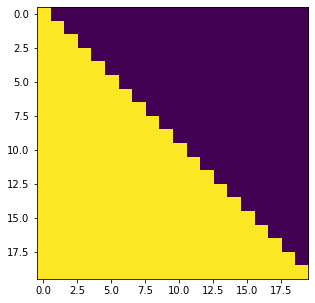

In [14]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 规范化层
规范化层的作用：它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后输出可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常慢。因此都会在一定层后接规范化层进行数值的规范化，使其特征数值在合理范围内。

Transformer中使用的normalization手段是layer norm，实现代码很简单，如下：

In [15]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, feature_size, eps=1e-6):
        # 初始化函数有两个参数，一个是features,表示词嵌入的维度,另一个是eps它是一个足够小的数，在规范化公式的分母中出现,防止分母为0，默认是1e-6。
        super(LayerNorm, self).__init__()
        # 根据features的形状初始化两个参数张量a2，和b2，第一初始化为1张量，也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是0，这两个张量就是规范化层的参数。因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子，使其即能满足规范化要求，又能不改变针对目标的表征，最后使用nn.parameter封装，代表他们是模型的参数
        self.a_2 = nn.Parameter(torch.ones(feature_size))
        self.b_2 = nn.Parameter(torch.zeros(feature_size))
        # 把eps传到类中
        self.eps = eps

    def forward(self, x):
        # 输入参数x代表来自上一层的输出，在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致，接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果。
        # 最后对结果乘以我们的缩放参数，即a2,*号代表同型点乘，即对应位置进行乘法操作，加上位移参b2，返回即可
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [16]:
# embedding_size=16
layer_norm = LayerNorm(16)
norm_x = layer_norm(position_enc_x)
position_enc_x, norm_x

(tensor([[[  0.0000,   0.3469,  -0.7491,   0.6070,  -1.5492,  -2.8974,  -3.5907,
             0.2504,  -2.1471,   5.5847,  11.6371,  -1.9434,   0.0000,  -4.6232,
             0.2133,  -0.0000],
          [  0.0000,  -5.4573,  -3.7686,   1.9659,   5.1254,  -0.9123,  -1.1379,
            -1.4928,   4.8002,   8.7096,   1.1290,   3.6947,  -2.1815,   0.8283,
             6.0025,   4.5009],
          [  3.0152,  -6.5201,  -3.4573,   1.8061,   0.0000,  -0.9289,  -1.1028,
            -1.4945,   0.0000,   8.7094,   1.1325,   3.6947,  -2.1804,   0.0000,
             6.0029,   4.5009],
          [ -4.5933,  -5.5700,  -0.1780,  -2.9321, -10.2470,   5.1914,   0.8832,
            -1.1694,  -5.3230,   1.8775,  -0.0000,  -6.8561,  -2.1840,   2.4458,
            -1.7266,   3.9137],
          [  6.2895,  -1.4905,   0.3104,  -0.1695,  -1.1165,  -2.9851,  -3.4505,
             0.2415,  -2.1027,   5.5838,  11.6511,  -1.9435,   1.1290,  -4.6233,
             0.2147,  -0.2102]]], grad_fn=<MulBackward0>),
 te

## Attention
Attention功能可以描述为将query和一组key-value映射到输出，其中query、key、value和输出都是向量。输出为value的加权和，其中每个value的权重通过query与相应key的计算得到。                                                                         
我们将particular attention称之为“缩放的点积Attention”(Scaled Dot-Product Attention")。其输入为query、key(维度是$d_k$)以及values(维度是$d_v$)。我们计算query和所有key的点积，然后对每个除以 $\sqrt{d_k}$, 最后用softmax函数获得value的权重。         

In [17]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # query,key,value均为[batch_size,sentence_len,embedding_size]
    # 首先取query的最后一维的大小，对应词嵌入维度
    d_k = query.size(-1)
    # 按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数得到注意力得分张量scores
    # src:scores.shape=[30,8,10,10] tgt:[30,8,9,9]
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # 接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的masked_fill方法，将掩码张量和scores张量每个位置一一比较，如果掩码张量则对应的scores张量用-1e9这个置来替换
        scores = scores.masked_fill(mask == 0, -1e9)

    # 对scores的最后一维进行softmax操作，使用F.softmax方法，这样获得最终的注意力张量
    p_attn = F.softmax(scores, dim=-1)

    # 之后判断是否使用dropout进行随机置0
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后，根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

In [18]:
position_enc_x.shape

torch.Size([1, 5, 16])

In [19]:
# query的最后一维的大小为embedding_size,理论上q,k,v通过input_x线性转换后得来的.
query, key, value = [torch.randn((1, 5, 16)) for i in range(3)]
output_x = attention(query,key,value)
output_x[0].shape,output_x[1].shape
# p_attn
# [[a11,a12,a13,a14,a15],
#  [a21,a22,a23,a24,a25],
#  [a31,a32,a33,a34,a35],
#  [a41,a42,a43,a44,a45],
#  [a51,a52,a53,a54,a55]]
# 其中a(i,j)表示第i个单词对第j个单词的注意力程度.

(torch.Size([1, 5, 16]), torch.Size([1, 5, 5]))

## 多头注意力机制

Transformer 的论文通过增加多头注意力机制（一组注意力称为一个 attention head），进一步完善了Self-Attention。这种机制从如下两个方面增强了attention层的能力：

- **它扩展了模型关注不同位置的能力**。在上面的例子中，第一个位置的输出 $z_1$ 包含了句子中其他每个位置的很小一部分信息，但$z_1$​仅仅是单个向量，所以可能仅由第1个位置的信息主导了。而当我们翻译句子：`The animal didn’t cross the street because it was too tired`时，我们不仅希望模型关注到"it"本身，还希望模型关注到"The"和"animal"，甚至关注到"tired"。这时，多头注意力机制会有帮助。
- **多头注意力机制赋予attention层多个“子表示空间”**。下面我们会看到，多头注意力机制会有多组 $W^Q, W^K W^V$ 的权重矩阵（在 Transformer 的论文中，使用了 8 组注意力),，因此可以将 $X$ 变换到更多种子空间进行表示。接下来我们也使用8组注意力头（attention heads））。每一组注意力的权重矩阵都是随机初始化的，但经过训练之后，每一组注意力的权重 $W^Q, W^K W^V$ 可以把输入的向量映射到一个对应的"子表示空间"。

In [20]:
class MultiheadAttention(nn.Module):
    # n_heads：多头注意力的数量
    # hid_dim：每个词输出的向量维度
    def __init__(self, hid_dim, n_heads, dropout):
        super(MultiheadAttention, self).__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads

        # 强制 hid_dim 必须整除 h
        assert hid_dim % n_heads == 0
        # 定义 W_q 矩阵
        self.w_q = nn.Linear(hid_dim, hid_dim)
        # 定义 W_k 矩阵
        self.w_k = nn.Linear(hid_dim, hid_dim)
        # 定义 W_v 矩阵
        self.w_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc = nn.Linear(hid_dim, hid_dim)
        self.do = nn.Dropout(dropout)
        # 缩放
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim // n_heads]))

    def forward(self, query, key, value, mask=None):
        # 注意 Q，K，V的在句子长度这一个维度的数值可以一样，可以不一样。
        # K: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # V: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # Q: [64,12,300], 假设batch_size 为 64，有 12 个词，每个词的 Query 向量是 300 维
        bsz = query.shape[0]
        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)
        # 这里把 K Q V 矩阵拆分为多组注意力
        # 最后一维就是是用 self.hid_dim // self.n_heads 来得到的，表示每组注意力的向量长度, 每个 head 的向量长度是：300/6=50
        # 64 表示 batch size，6 表示有 6组注意力，10 表示有 10 词，50 表示每组注意力的词的向量长度
        # K: [64,10,300] 拆分多组注意力 -> [64,10,6,50] 转置得到 -> [64,6,10,50]
        # V: [64,10,300] 拆分多组注意力 -> [64,10,6,50] 转置得到 -> [64,6,10,50]
        # Q: [64,12,300] 拆分多组注意力 -> [64,12,6,50] 转置得到 -> [64,6,12,50]
        # 转置是为了把注意力的数量 6 放到前面，把 10 和 50 放到后面，方便下面计算
        Q = Q.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)
        K = K.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)
        V = V.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)

        # 第 1 步：Q 乘以 K的转置，除以scale
        # [64,6,12,50] * [64,6,50,10] = [64,6,12,10]
        # attention：[64,6,12,10]
        attention = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # 如果 mask 不为空，那么就把 mask 为 0 的位置的 attention 分数设置为 -1e10，这里用“0”来指示哪些位置的词向量不能被attention到，比如padding位置，当然也可以用“1”或者其他数字来指示，主要设计下面2行代码的改动。
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        # 第 2 步：计算上一步结果的 softmax，再经过 dropout，得到 attention。
        # 注意，这里是对最后一维做 softmax，也就是在输入序列的维度做 softmax
        # attention: [64,6,12,10]
        attention = self.do(torch.softmax(attention, dim=-1))

        # 第三步，attention结果与V相乘，得到多头注意力的结果
        # [64,6,12,10] * [64,6,10,50] = [64,6,12,50]
        # x: [64,6,12,50]
        x = torch.matmul(attention, V)

        # 因为 query 有 12 个词，所以把 12 放到前面，把 50 和 6 放到后面，方便下面拼接多组的结果
        # x: [64,6,12,50] 转置-> [64,12,6,50]
        x = x.permute(0, 2, 1, 3).contiguous()
        # 这里的矩阵转换就是：把多组注意力的结果拼接起来
        # 最终结果就是 [64,12,300]
        # x: [64,12,6,50] -> [64,12,300]
        x = x.view(bsz, -1, self.n_heads * (self.hid_dim // self.n_heads))
        x = self.fc(x)
        return x


# batch_size 为 64，有 12 个词，每个词的 Query 向量是 300 维
query = torch.rand(64, 12, 300)
# batch_size 为 64，有 12 个词，每个词的 Key 向量是 300 维
key = torch.rand(64, 12, 300)
# batch_size 为 64，有 12 个词，每个词的 Value 向量是 300 维
value = torch.rand(64, 12, 300)
attention_fn = MultiheadAttention(hid_dim=300, n_heads=6, dropout=0.1)
output = attention_fn(query, key, value)
## output: torch.Size([64, 12, 300])
print(output.shape)

torch.Size([64, 12, 300])


### 简化代码

In [21]:
# 定义一个clones函数，来更方便的将某个结构复制若干份
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        # 在类的初始化时，会传入三个参数，h代表头数，d_model代表词嵌入的维度，dropout代表进行dropout操作时置0比率，默认是0.1
        super(MultiHeadedAttention, self).__init__()
        # 在函数中，首先使用了一个测试中常用的assert语句，判断h是否能被d_model整除，这是因为我们之后要给每个头分配等量的词特征，也就是embedding_dim/head个
        assert d_model % h == 0
        # 得到每个头获得的分割词向量维度d_k
        self.d_k = d_model // h
        # 传入头数h
        self.h = h

        # 创建linear层，通过nn的Linear实例化，它的内部变换矩阵是embedding_dim x embedding_dim，然后使用，为什么是四个呢，这是因为在多头注意力中，Q,K,V各需要一个，最后拼接的矩阵还需要一个，因此一共是四个
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        # self.attn为None，它代表最后得到的注意力张量，现在还没有结果所以为None
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        # 前向逻辑函数，它输入参数有四个，前三个就是注意力机制需要的Q,K,V，最后一个是注意力机制中可能需要的mask掩码张量，默认是None
        if mask is not None:
            # Same mask applied to all h heads.
            # 使用unsqueeze扩展维度，代表多头中的第n头
            mask = mask.unsqueeze(1)
        # 接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        # 首先利用zip将输入QKV与三个线性层组到一起，然后利用for循环，将输入QKV分别传到线性层中，做完线性变换后，开始为每个头分割输入，这里使用view方法对线性变换的结构进行维度重塑，多加了一个维度h代表头，这样就意味着每个头可以获得一部分词特征组成的句子，其中的-1代表自适应维度，计算机会根据这种变换自动计算这里的值，然后对第二维和第三维进行转置操作，为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子位置的关系，从attention函数中可以看到，利用的是原始输入的倒数第一和第二维，这样我们就得到了每个头的输入
        # src:query.shape=[30,10,512] tgt:query.shape=[30,9,512]
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        # 得到每个头的输入后，接下来就是将他们传入到attention中，这里直接调用我们之前实现的attention函数，同时也将mask和dropout传入其中
        # src:query.shape=[30,8,10,64] tgt:query.shape=[30,8,9,64]
        # 8*64 = 512
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        # 通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的形状以方便后续的计算，因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiguous方法。这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用，所以，下一步就是使用view重塑形状，变成和输入形状相同。
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        # 最后使用线性层列表中的最后一个线性变换得到最终的多头注意力结构的输出
        # src:return.shape=[30,10,512] tgt:return.shape=[30,9,512]
        return self.linears[-1](x)

 ## 前馈全连接层
除了attention子层之外，我们的编码器和解码器中的每个层都包含一个全连接的前馈网络，该网络在每个层的位置相同（都在每个encoder-layer或者decoder-layer的最后）。该前馈网络包括两个线性变换，并在两个线性变换中间有一个ReLU激活函数。

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                        

尽管两层都是线性变换，但它们在层与层之间使用不同的参数。另一种描述方式是两个内核大小为1的卷积。 输入和输出的维度都是 $d_{\text{model}}=512$, 内层维度是$d_{ff}=2048$。（也就是第一层输入512维,输出2048维；第二层输入2048维，输出512维）

In [23]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        #初始化函数有三个输入参数分别是d_model，d_ff，和dropout=0.1，第一个是线性层的输入维度也是第二个线性层的输出维度，因为我们希望输入通过前馈全连接层后输入和输出的维度不变，第二个参数d_ff就是第二个线性层的输入维度和第一个线性层的输出，最后一个是dropout置0比率。
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #输入参数为x，代表来自上一层的输出，首先经过第一个线性层，然后使用F中的relu函数进行激活，之后再使用dropout进行随机置0，最后通过第二个线性层w2，返回最终结果
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Encoder
编码器由N = 6个完全相同的层组成。
编码器的每层encoder包含Self Attention 子层和FFN子层，每个子层都使用了残差连接[(cite)](https://arxiv.org/abs/1512.03385)，和层标准化（layer-normalization） [(cite)](https://arxiv.org/abs/1607.06450)。

我们称呼子层为：$\mathrm{Sublayer}(x)$，每个子层的最终输出是$\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$。 dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html)被加在Sublayer上。

为了便于进行残差连接，模型中的所有子层以及embedding层产生的输出的维度都为 $d_{\text{model}}=512$。

In [24]:
# 定义一个clones函数，来更方便的将某个结构复制若干份
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """
    Encoder
    The encoder is composed of a stack of N=6 identical layers.
    """

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # 调用时会将编码器层传进来，我们简单克隆N分，叠加在一起，组成完整的Encoder
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

第一个子层包括一个**多头自注意力层**和**规范化层**以及一个**残差连接**

第二个子层包括一个**前馈全连接层**和**规范化层**以及一个**残差连接**

可以看到，两个子层的结构其实是一致的，只是中间核心层的实现不同.

![image-20211014164210704](https://gitee.com/shenhao-stu/picgo/raw/master/Others/image-20211014164210704.png)

下面的**SublayerConnection**类用来处理单个Sublayer的输出，该输出将继续被输入下一个Sublayer：

In [25]:
class SublayerConnection(nn.Module):
    """ 
    实现子层连接结构的类
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):

        # 原paper的方案
        #sublayer_out = sublayer(x)
        #x_norm = self.norm(x + self.dropout(sublayer_out))

        # 稍加调整的版本
        sublayer_out = sublayer(x)
        sublayer_out = self.dropout(sublayer_out)
        x_norm = x + self.norm(sublayer_out)
        return x_norm

注：上面的实现中，我对残差的链接方案进行了小小的调整，和原论文有所不同。把x从norm中拿出来，保证永远有一条“高速公路”，这样理论上会收敛的快一些，但我无法确保这样做一定是对的，请一定注意。

定义好了SubLayerConnection，我们就可以实现EncoderLayer的结构了

In [26]:
class EncoderLayer(nn.Module):
    "EncoderLayer is made up of two sublayer: self-attn and feed forward"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size   # embedding's dimention of model, 默认512

    def forward(self, x, mask):
        # attention sub layer,let self.self_attn use one arg by using lambda
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # feed forward sub layer
        z = self.sublayer[1](x, self.feed_forward)
        return z

## Decoder

解码器也是由N = 6 个完全相同的decoder层组成。

### 1. 解码器整体结构
解码器的作用：根据编码器的结果以及上一次预测的结果，输出序列的下一个结果。

整体结构上，解码器也是由N个相同层堆叠而成。构造代码如下：

In [27]:
# 使用类Decoder来实现解码器
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        # 初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N
        super(Decoder, self).__init__()
        # 首先使用clones方法克隆了N个layer，然后实例化一个规范化层，因为数据走过了所有的解码器层后最后要做规范化处理。
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        # forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出，source_mask，target_mask代表源数据和目标数据的掩码张量，然后就是对每个层进行循环，当然这个循环就是变量x通过每一个层的处理，得出最后的结果，再进行一次规范化返回即可。
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### 2. 解码器层
每个解码器层由三个子层连接结构组成
- 第一个子层连接结构包括一个**多头自注意力子层**和规范化层以及一个残差连接
- 第二个子层连接结构包括一个**多头注意力子层**和规范化层以及一个残差连接
- 第三个子层连接结构包括一个**前馈全连接子层**和规范化层以及一个残差连接。
![image-20211014165218933](https://gitee.com/shenhao-stu/picgo/raw/master/Others/image-20211014165218933.png)

有一个细节需要注意，第一个子层的多头注意力和编码器中完全一致，第二个子层，它的**多头注意力模块**中，**query来自上一个子层，key 和 value 来自编码器的输出**。可以这样理解，就是第二层负责，利用解码器已经预测出的信息作为query，去编码器提取的各种特征中，查找相关信息并融合到当前特征中，来完成预测。

In [28]:
# 使用DecoderLayer的类实现解码器层
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # 初始化函数的参数有5个，分别是size，代表词嵌入的维度大小，同时也代表解码器的尺寸，第二个是self_attn，多头自注意力对象，也就是说这个注意力机制需要Q=K=V，第三个是src_attn,多头注意力对象，这里Q!=K=V，第四个是前馈全连接层对象，最后就是dropout置0比率
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按照结构图使用clones函数克隆三个子层连接对象
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # forward函数中的参数有4个，分别是来自上一层的输入x，来自编码器层的语义存储变量memory，以及源数据掩码张量和目标数据掩码张量，将memory表示成m之后方便使用。
        m = memory
        # 将x传入第一个子层结构，第一个子层结构的输入分别是x和self-attn函数，因为是自注意力机制，所以Q,K,V都是x，最后一个参数时目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据。
        # 比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，但是我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，同样生成第二个字符或词汇时，模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 接着进入第二个子层，这个子层中常规的注意力机制，q是输入x;k,v是编码层输出memory，同样也传入source_mask，但是进行源数据遮掩的原因并非是抑制信息泄露，而是遮蔽掉对结果没有意义的padding。
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))

        # 最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果，这就是我们的解码器结构
        return self.sublayer[2](x, self.feed_forward)

## 模型输出

输出部分就很简单了，每个时间步都过一个 线性层 + softmax层

线性层的作用：通过对上一步的线性变化得到指定维度的输出，也就是转换维度的作用。转换后的维度对应着输出类别的个数，如果是翻译任务，那就对应的是文字字典的大小。

In [29]:
# 将线性层和softmax计算层一起实现，因为二者的共同目标是生成最后的结构
# 因此把类的名字叫做Generator，生成器类
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        # 初始化函数的输入参数有两个，d_model代表词嵌入维度，vocab.size代表词表大小
        super(Generator, self).__init__()
        # 首先就是使用nn中的预定义线性层进行实例化，得到一个对象self.proj等待使用
        # 这个线性层的参数有两个，就是初始化函数传进来的两个参数：d_model，vocab_size
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 前向逻辑函数中输入是上一层的输出张量x,在函数中，首先使用上一步得到的self.proj对x进行线性变化,然后使用F中已经实现的log_softmax进行softmax处理。
        return F.log_softmax(self.proj(x), dim=-1)

## 模型构建

In [30]:
# Model Architecture
# 使用EncoderDecoder类来实现编码器-解码器结构
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        # 初始化函数中有5个参数，分别是编码器对象，解码器对象,源数据嵌入函数，目标数据嵌入函数，以及输出部分的类别生成器对象.
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # input embedding module(input embedding + positional encode)
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed    # ouput embedding module
        self.generator = generator    # output generation module

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # 在forward函数中，有四个参数，source代表源数据，target代表目标数据,source_mask和target_mask代表对应的掩码张量,在函数中，将source source_mask传入编码函数，得到结果后与source_mask target 和target_mask一同传给解码函数
        memory = self.encode(src, src_mask)
        res = self.decode(memory, src_mask, tgt, tgt_mask)
        return res

    def encode(self, src, src_mask):
        # 编码函数，以source和source_mask为参数,使用src_embed对source做处理，然后和source_mask一起传给self.encoder
        src_embedds = self.src_embed(src)  # src_embedds.shape=[30,10,512]
        return self.encoder(src_embedds, src_mask)  # src_mask.shape=[30,1,10]

    def decode(self, memory, src_mask, tgt, tgt_mask):
        # 解码函数，以memory即编码器的输出，source_mask target target_mask为参数,使用tgt_embed对target做处理，然后和source_mask,target_mask,memory一起传给self.decoder
        target_embedds = self.tgt_embed(tgt)
        return self.decoder(target_embedds, memory, src_mask, tgt_mask)


# Full Model
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    构建模型
    params:
        src_vocab:
        tgt_vocab:
        N: 编码器和解码器堆叠基础模块的个数
        d_model: 模型中embedding的size，默认512
        d_ff: FeedForward Layer层中embedding的size，默认2048
        h: MultiHeadAttention中多头的个数，必须被d_model整除
        dropout:
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## 实战案例

下面我们用一个人造的玩具级的小任务，来实战体验下Transformer的训练，加深我们的理解，并且验证我们上面所述代码是否work。

任务描述：针对数字序列进行学习，学习的最终目标是使模型学会输出与输入的序列删除第一个字符之后的相同的序列，如输入[1,2,3,4,5]，我们尝试让模型学会输出[2,3,4,5]。

显然这对模型来说并不难，应该简单的若干次迭代就能学会。

代码实现的基本的步骤是：

第一步：构建并生成人工数据集

第二步：构建Transformer模型及相关准备工作

第三步：运行模型进行训练和评估

第四步：使用模型进行贪婪解码

训练的大致流程如下：

### 批处理和掩码

In [31]:
class Batch:
    "Object for holding a batch of data with mask during training."

    def __init__(self, src, trg=None, pad=0):
        # src,trg [30,10]
        self.src = src
        # src_mask.shape=[30,1,10]
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]  # [30,9]
            self.trg_y = trg[:, 1:]  # [30,9]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        # tgt.shape [30,9]
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)  # [30,1,9]
        tgt_mask = tgt_mask & subsequent_mask(
            tgt.size(-1)).type_as(tgt_mask.data)  # subsequent_mask.shape [1,9,9]
        # tgt_mask=[30,9,9]
        return tgt_mask

### Training Loop

In [32]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    # batch.src.shape=[30,10] batch.trg.shape=[30,9]
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### Optimizer
我们使用Adam优化器[(cite)](https://arxiv.org/abs/1412.6980)，其中 $\beta_1=0.9$, $\beta_2=0.98$并且$\epsilon=10^{-9}$。我们根据以下公式在训练过程中改变学习率：                                         
$$
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$
这对应于在第一次$warmup\_steps$步中线性地增加学习速率，并且随后将其与步数的平方根成比例地减小。我们使用$warmup\_steps=4000$。                            

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."

    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
             min(step ** (-0.5), step * self.warmup ** (-1.5)))


def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> 以下是此模型针对不同模型大小和优化超参数的曲线示例。

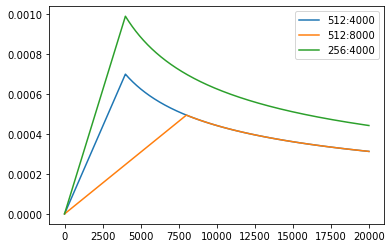

In [34]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i)
                                for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

### 正则化
### 标签平滑

在训练过程中，我们使用的label平滑的值为$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567)。虽然对label进行平滑会让模型困惑，但提高了准确性和BLEU得分。

> 我们使用KL div损失实现标签平滑。我们没有使用one-hot独热分布，而是创建了一个分布，该分布设定目标分布为1-smoothing，将剩余概率分配给词表中的其他单词。

In [35]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.requires_grad_(False))

下面我们看一个例子，看看平滑后的真实概率分布。

C:\Users\56550\AppData\Local\Temp/ipykernel_30536/410927135.py:19: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  mask = torch.nonzero(target.data == self.padding_idx)


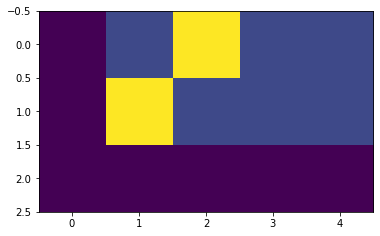

In [36]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(predict.log(),
         torch.LongTensor([2, 1, 0]))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

In [37]:
print(crit.true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


由于标签平滑的存在，如果模型对于某个单词特别有信心，输出特别大的概率，会被惩罚。如下代码所示，随着输入x的增大，x/d会越来越大，1/d会越来越小，但是loss并不是一直降低的。

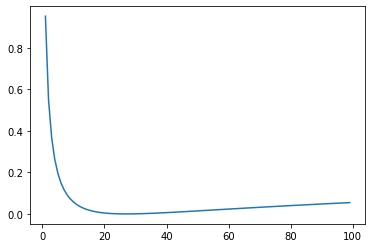

In [38]:
crit = LabelSmoothing(5, 0, 0.1)


def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    # print(predict)
    return crit(predict.log(),
                torch.LongTensor([1])).item()


y = [loss(x) for x in range(1, 100)]
x = np.arange(1, 100)
plt.plot(x, y)

## 实例
### 合成数据

In [39]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = data.long().requires_grad_(False)
        tgt = data.long().requires_grad_(False)
        yield Batch(src, tgt, 0)

### 损失函数计算

In [40]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

### 贪婪解码

In [41]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.217873 Tokens per Sec: 413.666809
Epoch Step: 1 Loss: 2.044819 Tokens per Sec: 567.102539
tensor(2.0707)
Epoch Step: 1 Loss: 2.084461 Tokens per Sec: 378.063538
Epoch Step: 1 Loss: 1.725667 Tokens per Sec: 655.580994
tensor(1.7515)
Epoch Step: 1 Loss: 2.133247 Tokens per Sec: 411.176636
Epoch Step: 1 Loss: 1.681059 Tokens per Sec: 684.259460
tensor(1.6964)
Epoch Step: 1 Loss: 1.905264 Tokens per Sec: 442.886932
Epoch Step: 1 Loss: 1.337842 Tokens per Sec: 659.193665
tensor(1.3322)
Epoch Step: 1 Loss: 1.527641 Tokens per Sec: 457.912903
Epoch Step: 1 Loss: 1.006559 Tokens per Sec: 614.896240
tensor(0.9990)
Epoch Step: 1 Loss: 1.470397 Tokens per Sec: 460.250824
Epoch Step: 1 Loss: 0.759082 Tokens per Sec: 687.745728
tensor(0.7827)
Epoch Step: 1 Loss: 1.000888 Tokens per Sec: 470.682098
Epoch Step: 1 Loss: 0.634258 Tokens per Sec: 603.893799
tensor(0.6654)
Epoch Step: 1 Loss: 0.799201 Tokens per Sec: 457.523834
Epoch Step: 1 Loss: 0.370392 Tokens per Sec: 654.398865

In [42]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           ys,
                           subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


model.eval()
src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 2, 3, 5, 6, 7, 8, 9, 8, 9]])
